# packages 

In [1]:
import numpy as np
import xarray
from funcs import return_hamming
from scipy import fftpack
from scipy.interpolate import RectBivariateSpline

In [235]:
%matplotlib inline
import matplotlib.pyplot as plt
fs=14
plt.rc("font",size=fs)

# io

In [3]:
fpath    = "/Volumes/Baby-Orange/XPIA-NCAR/rawest/WRF_LES_25m_3D_2015-03-20_14:00.nc"
all_data = xarray.open_dataset(fpath)

# grab variable and perturbation

In [4]:
w_mean   = np.mean(all_data["w"].values,axis=(1,2))
w_prime  = all_data["w"].values - w_mean[:,np.newaxis,np.newaxis]
array    = w_prime[8,...].copy()

# get 2d spectra

In [5]:
# 1. get 2-d arrays of perturbations
(npts,npts) = array.shape

# 3. apply window (to minimize noise since the arrays are not periodic in space)
hamm_2d = return_hamming(Nx=npts,Ny=npts)    
array_windowed = array * hamm_2d

# 4. apply fft
fftarray  = fftpack.fft2(array_windowed)

# get psd
fftarray_shifted = fftpack.fftshift(fftarray)
psd_2d   = np.log10(np.abs(fftarray_shifted[1:,1:])**2)

# get frequencies

/Users/pdoubraw/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [6]:
d  = 25.0
fr = fftpack.fftfreq(npts, d=d)
fr = fr[1:]

In [7]:
[fr_x,fr_y]=np.meshgrid(np.sort(fr),np.sort(fr))

## quick visualization

In [78]:
xticks_wavelength = [-30000,-100,-50,50,100]
xticks_wavenum    = [1/a for a in xticks_wavelength]
xticks_labels     = ["{0:.0f}".format(a) for a in xticks_wavelength]
idx_center        = np.where(np.abs(np.array(xticks_wavelength))>20000)[0][0]
xticks_labels[idx_center] = "+-30000"

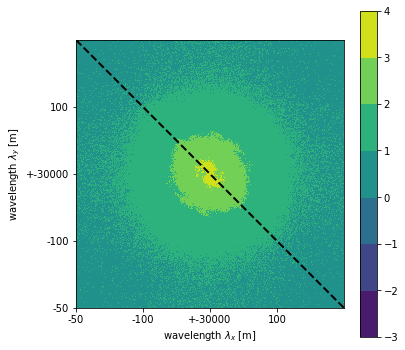

In [79]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111,aspect="equal")
p = ax.contourf(fr_x,fr_y,psd_2d,levels=np.arange(-3,4.1,1))

ax.set_xticks(xticks_wavenum)
ax.set_xticklabels(xticks_labels)
ax.set_xlabel("wavelength $\lambda_x$ [m]")

ax.set_yticks(xticks_wavenum)
ax.set_yticklabels(xticks_labels)
ax.set_ylabel("wavelength $\lambda_y$ [m]")

ax.plot([np.max(fr_x),np.min(fr_y)],[np.min(fr_x),np.max(fr_y)],'--k',lw=2)

plt.colorbar(p)

## cartesian to polar

In [228]:
radii_wavelength = np.arange(50,300,2) 
radii_wavelength = np.append(radii_wavelength, np.arange(300,3000,20)  )
radii_wavelength = np.append(radii_wavelength, np.arange(3000,30000.1,250)  )
radii_wavenumber = 1/radii_wavelength
nr               = len(radii_wavelength)
thetas           = np.radians(np.arange(135,315.1,1))
ntheta           = len(thetas)

theta_polar      = np.zeros((nr,ntheta))
x_polar          = np.zeros((nr,ntheta))
y_polar          = np.zeros((nr,ntheta))
psd_polar        = np.zeros((nr,ntheta))
radii_polar      = np.zeros((nr,ntheta))

for ir,r in enumerate(radii_wavenumber):
    for itheta,theta in enumerate(thetas):
        x = r*np.cos(theta)
        y = r*np.sin(theta)         
        val = f(x,y)[0][0]

        x_polar[ir,itheta]     = x
        y_polar[ir,itheta]     = y 
        psd_polar[ir,itheta]   = val
        theta_polar[ir,itheta] = theta
        radii_polar[ir,itheta] = r

### visualize polar data in cartesian and polar plots

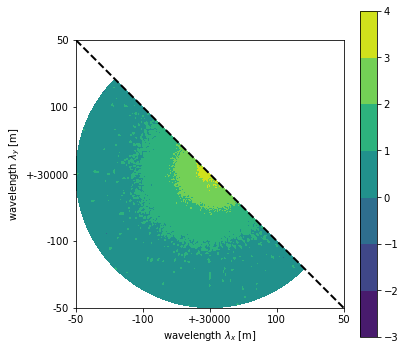

In [229]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111,aspect='equal')
p = ax.contourf(x_polar,y_polar,psd_polar,levels=np.arange(-3,4.1,1))

ax.set_xticks(xticks_wavenum)
ax.set_xticklabels(xticks_labels)
ax.set_xlabel("wavelength $\lambda_x$ [m]")
ax.set_xlim([-1/50,1/50])

ax.set_yticks(xticks_wavenum)
ax.set_yticklabels(xticks_labels)
ax.set_ylabel("wavelength $\lambda_y$ [m]")
ax.set_ylim([-1/50,1/50])

ax.plot([np.max(fr_x),np.min(fr_y)],[np.min(fr_x),np.max(fr_y)],'--k',lw=2)

plt.colorbar(p)

[Text(0, 0, '50 m'), Text(0, 0, '100 m'), Text(0, 0, '10000 m')]

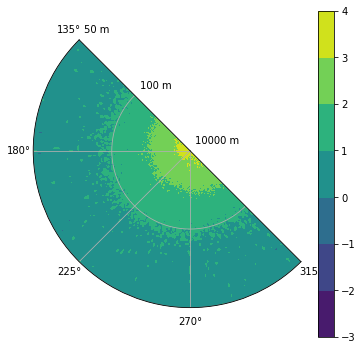

In [230]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111,projection='polar')
p = ax.contourf(theta_polar,radii_polar,psd_polar,levels=np.arange(-3,4.1,1))
plt.colorbar(p)
ax.set_xlim([np.radians(135),np.radians(315)])
ax.set_xticks(np.radians(np.arange(135,315.1,45)))
ax.set_yticks([1/50, 1/100, 1/10000])
ax.set_yticklabels(["50 m","100 m","10000 m"])

# junkyard

In [231]:
psd_polar_mean   = np.mean(psd_polar,1)
radii_polar_mean = np.mean(radii_polar,1)

In [243]:
10**-3

0.001

Text(0, 0.5, 'Azimuthally averaged, two-dimensional\nPower spectrum [m$^2$/s$^2$]')

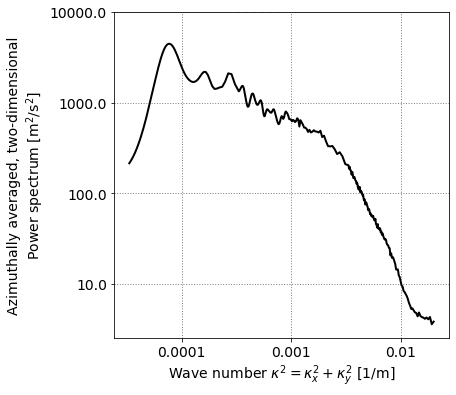

In [253]:
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111)
ax.grid(color='gray', linestyle=':', linewidth=1)
# ax.plot(np.log10(radii_wavenumber),psd_polar_mean,'xk',ms=5)
ax.plot(np.log10(radii_wavenumber),psd_polar_mean,'-k',lw=2)

xticks = np.arange(-4,-1,1)
ax.set_xticks(xticks)
ax.set_xticklabels(["{0}".format(10**(float(a))) for a in xticks ])
ax.set_xlabel("Wave number $\kappa^2=\kappa_x^2+\kappa_y^2$ [1/m]")

yticks = np.arange(1,4.1,1)
ax.set_yticks(yticks)
ax.set_yticklabels(["{0}".format(10**(float(a))) for a in yticks ])
ax.set_ylabel("Azimuthally averaged, two-dimensional\nPower spectrum [m$^2$/s$^2$]")

In [247]:
1/0.01

100.0

In [248]:
1/0.0001

10000.0